In [133]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [211]:
from epimodel import EpidemiologicalParameters, DefaultModel, preprocess_data
from epimodel.pymc3_models.base_model import produce_CIs, add_cms_to_plot

import numpy as np
import pymc3 as pm
import pickle

from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

from ipywidgets import *

In [135]:
data = preprocess_data('../double-entry-data/double_entry_final.csv', last_day='2020-05-30', smoothing=1)
data.mask_reopenings(print_out = False)

Dropping NPI Travel Screen/Quarantine
Dropping NPI Travel Bans
Dropping NPI Public Transport Limited
Dropping NPI Internal Movement Limited
Dropping NPI Public Information Campaigns
Dropping NPI Symptomatic Testing
Masking invalid values


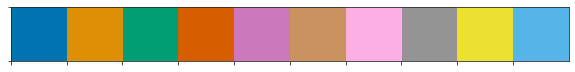

In [136]:
current_palette = sns.color_palette('colorblind')
sns.palplot(current_palette)

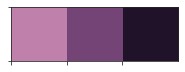

In [137]:
# cols = sns.cubehelix_palette(3, start=0, light=0.7, dark=0.3, rot=0.2)
cols = sns.cubehelix_palette(3, start=0.2, light=0.6, dark=0.1, rot=0.2)
sns.palplot(cols)

In [188]:
trace = pickle.load(open("traces/final_full.pkl", "rb"))

In [139]:
from matplotlib.gridspec import GridSpec

derived_features = [
 ("Mask-wearing mandatory in\n(some) public spaces", [0]),
 ("Gatherings limited to\n1000 people or less", [1]),
 ("Gatherings limited to\n100 people or less", [2, 1]),
 ("Gatherings limited to\n10 people or less", [3, 2, 1]),
 ("Some businesses\nclosed", [4]),
 ("Most nonessential\nbusinesses closed", [5, 4]),
 ("Schools and universities\nclosed", [6, 7]),
 ("Stay-at-home order\n(with exemptions)", [8]),  
 ]

cm_plot_style = [
            ("\uf963", "black"), # mask
            ("\uf0c0", cols[0]), # ppl
            ("\uf0c0", cols[1]), # ppl
            ("\uf0c0", cols[2]), # ppl
            ("\uf07a", cols[0]), # shop 1
            ("\uf07a", cols[2]), # shop2
            ("\uf549", "black"), # school
            ("\uf19d", "black"), # university
            ("\uf965", "black") # home
]

features = [x for x, _ in derived_features]

res = trace.CMReduction
nS, _ = res.shape
nF = len(derived_features)

derived_res = np.zeros((nS, nF))


for f_i, (f, prodrows) in enumerate(derived_features):
    samples = np.ones(nS)
    for r in prodrows:
        samples = samples * res[:, r] 
    derived_res[:, f_i] = samples

derived_res = 100*(1-derived_res)

def produce_ranges(trace):
    means = np.mean(trace, axis=0)
    med = np.median(trace, axis=0)
    li = np.percentile(trace, 2.5, axis=0)
    ui = np.percentile(trace, 97.5, axis=0)
    lq = np.percentile(trace, 25, axis=0)
    uq = np.percentile(trace, 75, axis=0)
    return means, med, li, ui, lq, uq


mn, med, li, ui, lq, uq = produce_ranges(derived_res)

N_cms = mn.size

fp2 = FontProperties(fname=r"../../fonts/Font Awesome 5 Free-Solid-900.otf")

fig = plt.figure(figsize=(5.5, 6), dpi=300)

gs = GridSpec(3, 2, figure=fig)
ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=2, rowspan=2))

plt.plot([0, 0], [1, -(N_cms)], "--", color=cols[0], linewidth=0.5)
y_vals = -1 * np.arange(N_cms)

xrange = np.array([-100, 100])
for height in range(0, nF+2, 2):
        plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.5, linewidth=0)
    
plt.scatter(med, y_vals, marker="|", color="black", s=55)

for cm in range(N_cms):
    plt.plot([li[cm], ui[cm]], [y_vals[cm], y_vals[cm]], "black", alpha=0.25, linewidth=3)
    plt.plot([lq[cm], uq[cm]], [y_vals[cm], y_vals[cm]], "black", alpha=0.75, linewidth=3)

x_min = -25
x_max = 75
plt.xlim([x_min, x_max])
xtick_vals = [-25, 0, 25, 50, 75, 100]
xtick_str = [f"{x:.0f}%" for x in xtick_vals]
plt.ylim([-(N_cms - 0.5), 0.5])

x_r = np.abs(x_min - x_max)
for cm in range(N_cms):
    for i, val in enumerate(derived_features[cm][1]):
        if val < len(cm_plot_style):
            col = cm_plot_style[val][1]
        else:
            col = "k"
        plt.text(x_min - 6.5 - 7.5*i, -cm, cm_plot_style[val][0], horizontalalignment='center', verticalalignment='center',
                     fontproperties=fp2, fontsize=10, color=col)

ax = plt.gca()
plt.yticks(-np.arange(N_cms), [f"{f[0]}" for f in derived_features], fontsize=8, ha="left")
yax = ax.get_yaxis()
yax.set_tick_params(pad=120)

for i, (ticklabel, tickloc) in enumerate(zip(ax.get_yticklabels(), ax.get_yticks())):
    if i < len(cm_plot_style):
            col = cm_plot_style[i][1]
    else:
        col = "k"
    ticklabel.set_color(col)

plt.xticks(xtick_vals, xtick_str, fontsize=8)
plt.xlabel("Average marginal multiplicative reduction in $R$,\nin the context of our data", fontsize=8)
# plt.text(0, -0.1, "Doubles\nTransmission", fontsize=6, ha='center', va='center',  transform=ax.transAxes, style='italic')
plt.text(1, -0.1, "Ends\nTransmission", fontsize=6, ha='center',  va='center', transform=ax.transAxes, style='italic')
sns.despine()

ax1 = plt.subplot(gs.new_subplotspec((2, 0), colspan=1, rowspan=1))
data.conditional_activation_plot(cm_plot_style, newfig=False, skip_yticks=True,)

ax1 = plt.subplot(gs.new_subplotspec((2, 1), colspan=1, rowspan=1))
data.cumulative_days_plot(cm_plot_style, skip_yticks=True, newfig=False)

plt.tight_layout()
plt.savefig("figs/FigureEF.pdf", bbox_inches="tight")

'Font Awesome 5 Free-Solid-900.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


[0.4627010031973002, 0.2693410356621817, 0.46634810758714684]

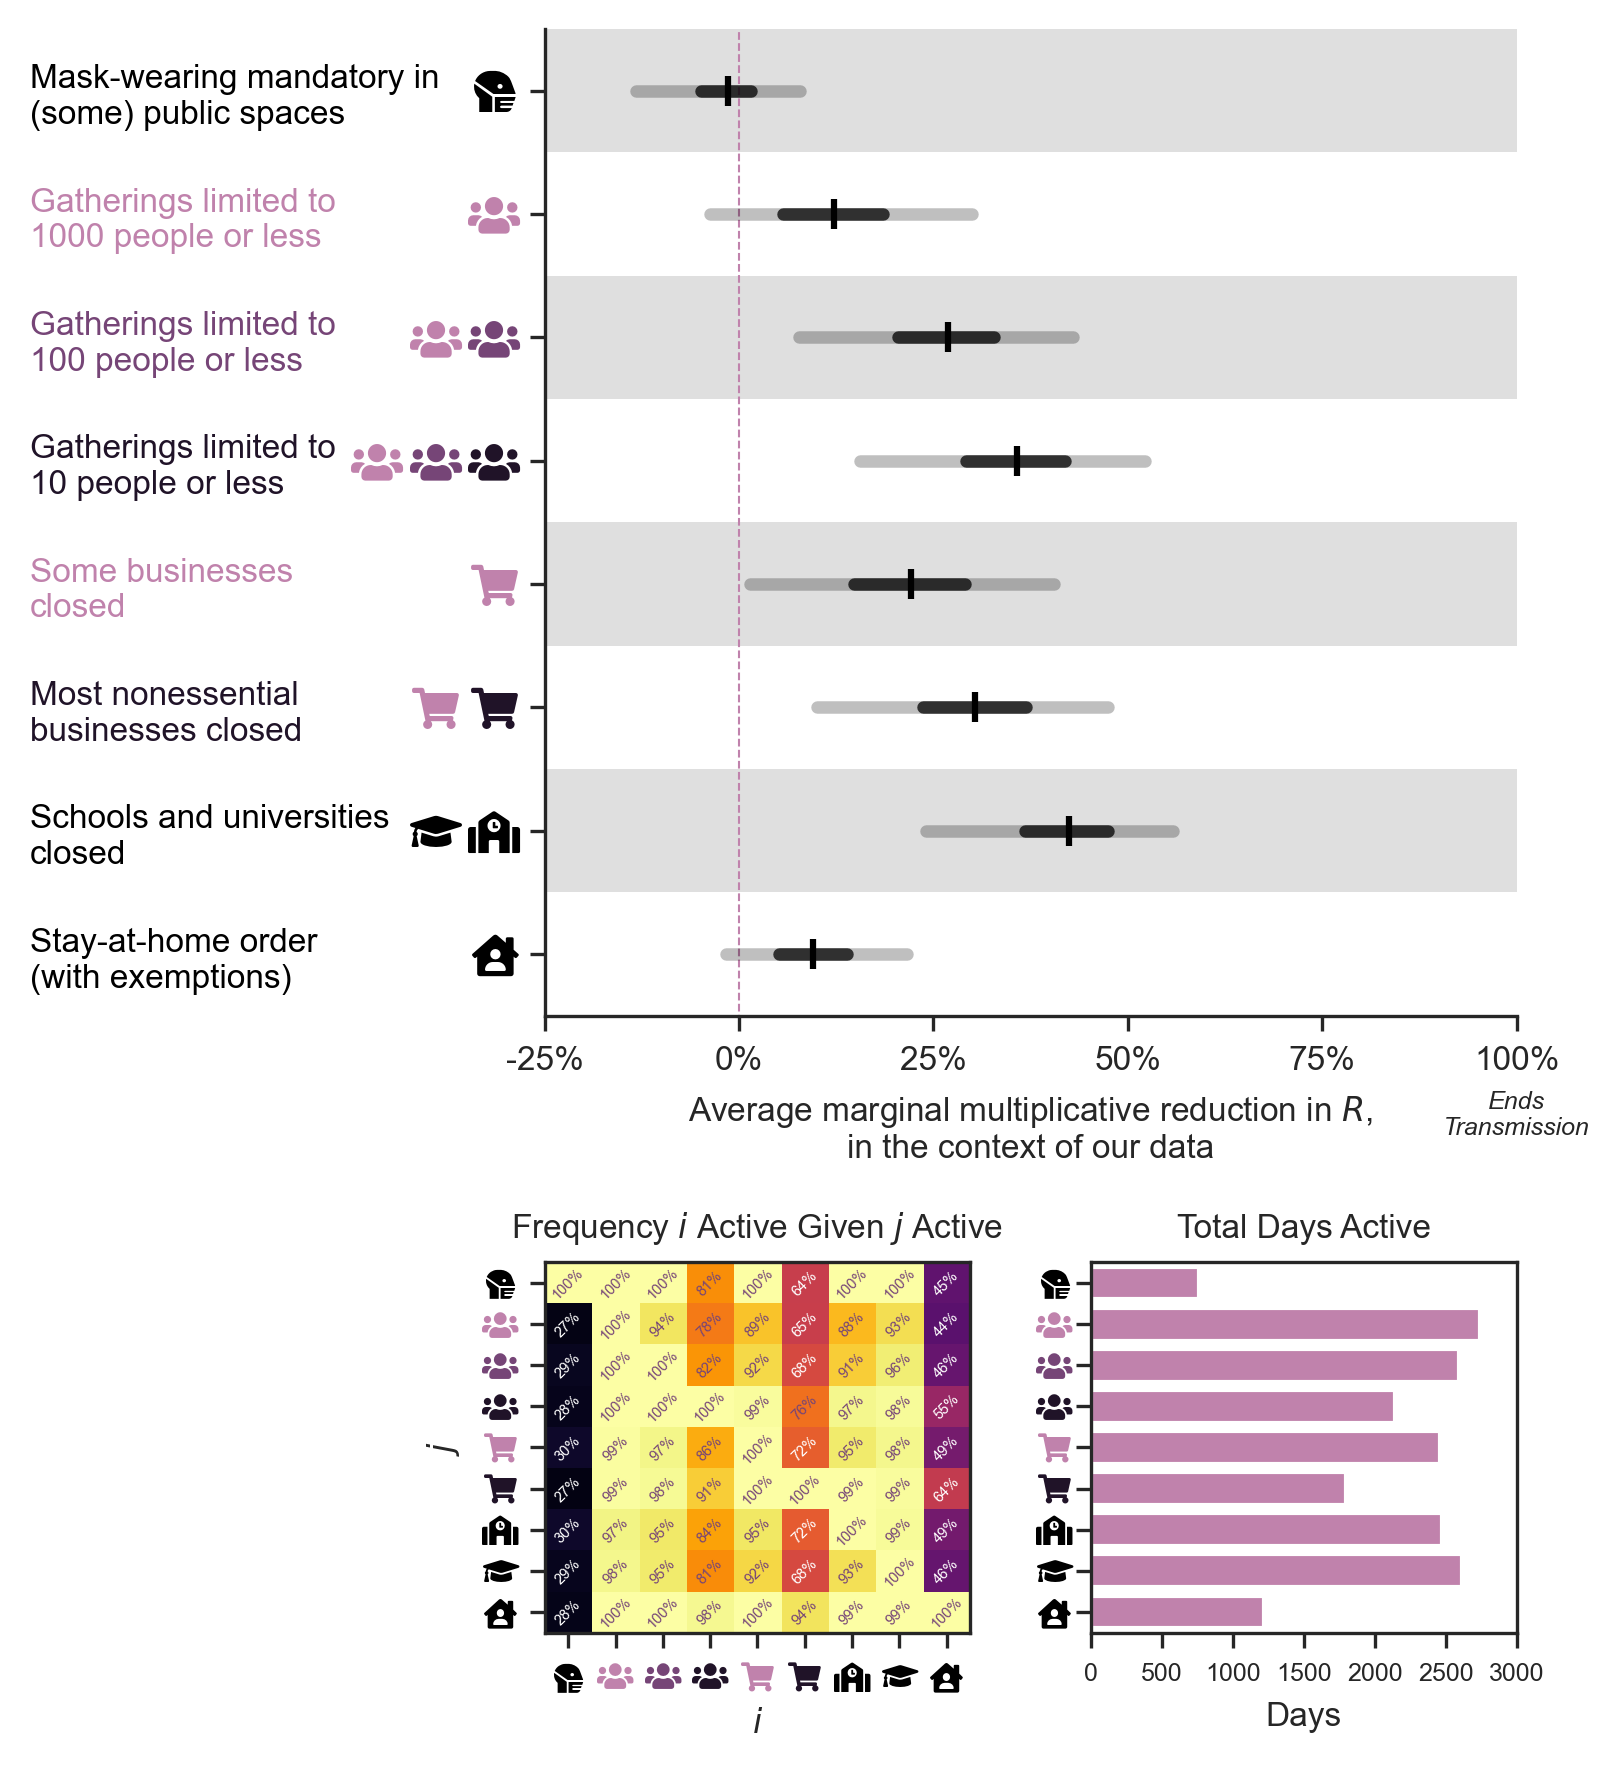

In [140]:
cols[1]

In [141]:
f;

# Pareto Graphs

In [142]:
schools_index = data.CMs.index("School Closure")
uni_index = data.CMs.index("University Closure")

pkg_mask = np.ones(len(data.CMs))
pkg_mask[uni_index] = 0

In [143]:
stk = np.hstack([data.ActiveCMs[r, :, :] for r in range(len(data.Rs))])
unique_columns, counts = np.unique(stk, return_counts = True, axis=1)
nCMs, nPkgs = unique_columns.shape
n_active = np.zeros(nPkgs)
for p in range(nPkgs):
    n_active[p] = np.sum(unique_columns[:, p]*pkg_mask)
    if unique_columns[schools_index, p] == 1 and unique_columns[uni_index, p] == 0:
        counts[p] = 0
    
    if unique_columns[schools_index, p] == 0 and unique_columns[uni_index, p] == 1:
        counts[p] = 0

In [144]:
display_together = [None, 2, 3, None, 5, None, None, None,None]

In [145]:
for d, dt in zip(data.CMs, display_together):
    print(d)
    if dt is not None:
        print(f"  with {data.CMs[dt]}")

Mask Wearing
Gatherings <1000
  with Gatherings <100
Gatherings <100
  with Gatherings <10
Gatherings <10
Some Businesses Suspended
  with Most Businesses Suspended
Most Businesses Suspended
School Closure
University Closure
Stay Home Order


In [146]:
def traverse(cm_i, pkg):
    dt = display_together[cm_i]
    
    if dt == None:
        return 0
    elif pkg[dt] == 0: 
        return 0
    elif pkg[dt] == 1:
        return 1 + traverse(dt, pkg)
    
    
def effective_active(pkg):
    n_active = 0
    for cm_i, cm in enumerate(pkg):
        if cm == 1:
            if traverse(cm_i, pkg) == 0:
                n_active += 1
    return n_active

In [149]:
import seaborn as sns
sns.set_style("ticks")
colors = sns.color_palette()

fig = plt.figure(figsize=(5,4), dpi=500)

# plt.subplot(121)
# for p in range(nPkgs):
#     pkg = unique_columns[:, p]
#     count_p = counts[p]
#     n_active_p = int(np.sum(pkg))
#     display_mc = 1
#     if np.sum(count_p < counts[n_active == n_active_p]) < display_mc:
#         if n_active_p > 0:
            
#             if n_active_p == 1:
#                 marker_size = 100*2
#                 text_size = 8
#                 r = 0.2
#             elif n_active_p < 4:
#                 marker_size = 300*2
#                 text_size = 8
#                 r = 0.22
#             elif n_active_p < 7:
#                 marker_size = 350*2
#                 text_size = 7.5
#                 r = 0.26
#             else:
#                 marker_size = 400*2
#                 text_size = 7
#                 r = 0.26
            
#             vals = np.ones(nS)
#             for c_i in range(nCMs):
#                 if pkg[c_i] != 0:
#                     vals = vals * trace.CMReduction[:, c_i]
#             R_vals = 0.999/vals
            
#             plt.scatter(n_active_p, np.median(R_vals), color="black", facecolor="white", s=marker_size, zorder=0, linewidth=0.5)
#             plt.plot([n_active_p, n_active_p], [np.percentile(R_vals, 2.5), np.percentile(R_vals, 97.5)], zorder=-1, color="lightgray", linewidth=28)
#             plt.plot([n_active_p, n_active_p], [np.percentile(R_vals, 25), np.percentile(R_vals, 75)], zorder=-1, color="gray", linewidth=28)
#             plt.plot([n_active_p-0.475, n_active_p+0.475], [np.percentile(R_vals, 50), np.percentile(R_vals, 50)], zorder=-3, color="black", linewidth=2)
            
#             if n_active_p > 1:
#                 points = [(np.cos(2*np.pi/n_active_p*x -np.pi/2)*r,np.sin((2*np.pi/n_active_p*x) -np.pi/2)*r) for x in range(0,n_active_p+1)]
#                 for c_i, c in enumerate(np.nonzero(pkg)[0].tolist()): 
#                     plt.text(n_active_p + points[c_i][0], np.median(R_vals) + points[c_i][1], cm_plot_style[c][0], zorder=2, color=cm_plot_style[c][1], fontproperties=fp2, ha="center", va="center", size=text_size)
#             else:
#                 nz = np.nonzero(pkg)[0].tolist()[0]
#                 plt.text(n_active_p , np.median(R_vals), cm_plot_style[nz][0], zorder=2, color=cm_plot_style[nz][1], fontproperties=fp2, ha="center", va="center", size=text_size)

# plt.xlabel("Number NPIs Active", fontsize=12)
# plt.ylabel("Maximum $R_0$\nthat can be brought below 1", fontsize=12)
# plt.xticks(np.arange(1, 10), fontsize=10)
# plt.yticks(fontsize=10)
# plt.ylim([0, 9])
# plt.xlim([0, 9.5])

# plt.subplot(122)
display_mc = 1
for p in range(nPkgs):
    pkg = unique_columns[:, p]
    count_p = counts[p]
    n_active_p = int(np.sum(pkg*pkg_mask))
    if np.sum(count_p < counts[n_active == n_active_p]) < display_mc:
        if n_active_p > 0:
            
            if n_active_p == 1:
                marker_size = 100*2
                text_size = 8
                r = 0.2
            elif n_active_p < 4:
                marker_size = 300*2
                text_size = 8
                r = 0.22
            elif n_active_p < 7:
                marker_size = 350*2
                text_size = 7.5
                r = 0.26
            else:
                marker_size = 400*2
                text_size = 7
                r = 0.26
            
            vals = np.ones(nS)
            for c_i in range(nCMs):
                if pkg[c_i] != 0:
                    vals = vals * trace.CMReduction[:, c_i]
            R_vals = 3.3 * vals
            
            plt.scatter(n_active_p, np.median(R_vals), color="black", facecolor="white", s=marker_size, zorder=0, linewidth=0.5)
            plt.plot([n_active_p, n_active_p], [np.percentile(R_vals, 2.5), np.percentile(R_vals, 97.5)], zorder=-1, color="lightgray", linewidth=10*3)
            plt.plot([n_active_p, n_active_p], [np.percentile(R_vals, 25), np.percentile(R_vals, 75)], zorder=-1, color="gray", linewidth=10*3) 
            plt.plot([n_active_p-0.475, n_active_p+0.475], [np.percentile(R_vals, 50), np.percentile(R_vals, 50)], zorder=-3, color="black", linewidth=2)
            
            
            if n_active_p > 1:
                points = [(np.cos(2*np.pi/n_active_p*x -np.pi/2)*r,np.sin((2*np.pi/n_active_p*x) -np.pi/2)*r*0.6) for x in range(0,n_active_p+1)]
                for c_i, c in enumerate(np.nonzero(pkg)[0].tolist()): 
                    plt.text(n_active_p + points[c_i][0], np.median(R_vals) + points[c_i][1], cm_plot_style[c][0], zorder=2, color=cm_plot_style[c][1], fontproperties=fp2, ha="center", va="center", size=text_size)
            else:
                nz = np.nonzero(pkg)[0].tolist()[0]
                plt.text(n_active_p , np.median(R_vals), cm_plot_style[nz][0], zorder=2, color=cm_plot_style[nz][1], fontproperties=fp2, ha="center", va="center", size=text_size)
plt.ylim([0, 4])
plt.xlim([0, 9.5])
plt.plot([-1, 10], [1, 1], "--", linewidth=1, color=cols[0], zorder=-5)
plt.xlabel("Number NPIs Active", fontsize=12)
plt.ylabel("Resulting $R$ if $R_0=3.3$", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
sns.despine()
plt.tight_layout()

cms = ["Mask Wearing", "Gatherings <1000", "Gatherings <100", "Gatherings <10", "Some Businesses\nSuspended", "Most Businesses\nSuspended", "School Closure", "University Closure", "Stay Home Order\n(with exemptions)"]
for indx, f in enumerate(data.CMs):
    fig.text(-0.015 + 0.1 + 0.195 * (indx%5), -0.05 * np.floor((indx/5)) , cm_plot_style[indx][0], fontproperties=fp2,  color=cm_plot_style[indx][1], size=9, va="center", ha="left", clip_on=True, zorder=1)
    fig.text(-0.015 + 0.12 + 0.195 * (indx%5), -0.00008 + -0.05 * np.floor((indx/5)), cms[indx], size=7, va="center", ha="left")

plt.savefig(f"figs/main/FigurePR.pdf", bbox_inches='tight')

'Font Awesome 5 Free-Solid-900.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


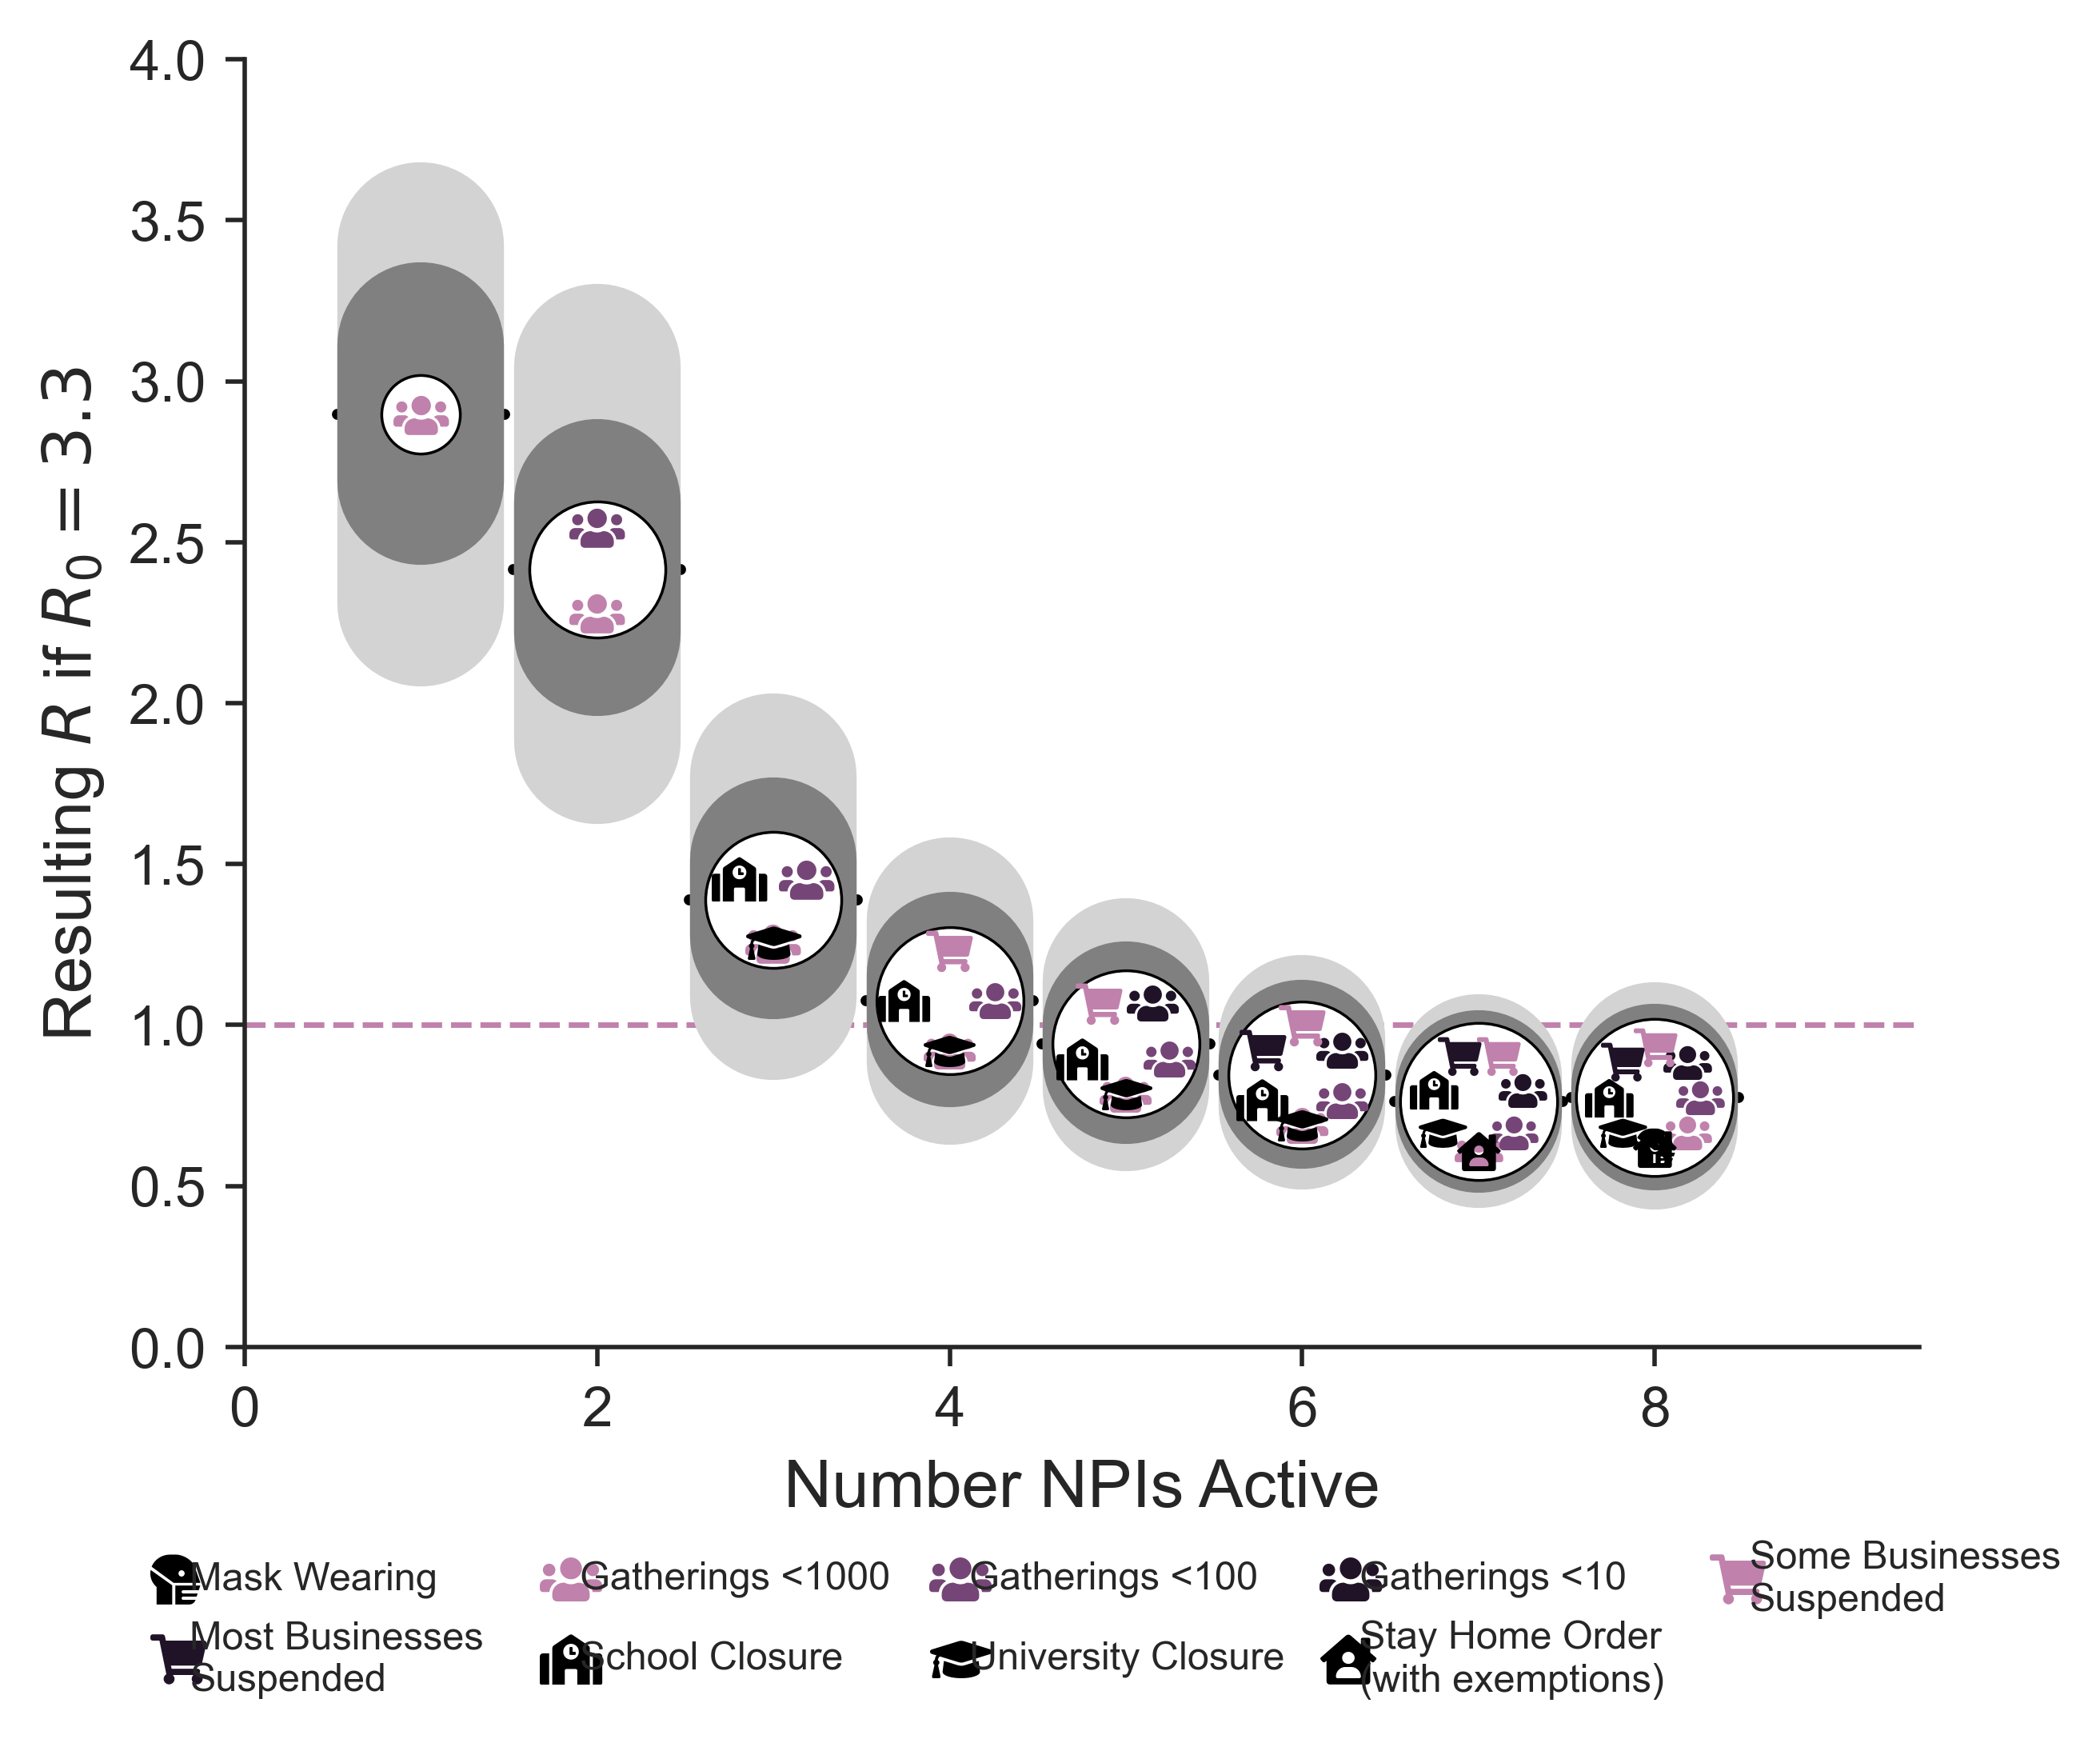

In [150]:
f;

# Numerical Values

In [ ]:
for cm_i, cm in enumerate(derived_features):
    print(f"{cm[0]}")
    print(f"  {np.mean(derived_res[:, cm_i]):.3f}% [{np.percentile(derived_res[:, cm_i], 2.5):.3f} ... {np.percentile(derived_res[:, cm_i], 50):.3f} ... {np.percentile(derived_res[:, cm_i], 97.5):.3f}] std: {np.std(derived_res[:, cm_i]):.3f}% Credence Positive: {100 * np.mean(derived_res[:, cm_i] > 0):.3f}%")

# Region Rs

In [ ]:
for r_i, r in enumerate(data.Rs):
    print(f"{r}: R_0 = {np.mean(trace.RegionR[:, r_i]):.2f} [{np.percentile(trace.RegionR[:, r_i], 2.5):.2f} ... {np.percentile(trace.RegionR[:, r_i], 97.5):.2f}]")

# Correlation Plot

In [125]:
res = trace.CMReduction[:, [0, 1, 2, 3, 4, 5, 6, 8]]
res[:, 6] = trace.CMReduction[:, 7] * res[:, 6]

cms = ["Mask-wearing", "Gatherings <1000", "Gatherings <100", "Gatherings <10", "Some businesses closed", "Most businesses closed", "Schools and univeristies closed", "Stay-at-home order"]

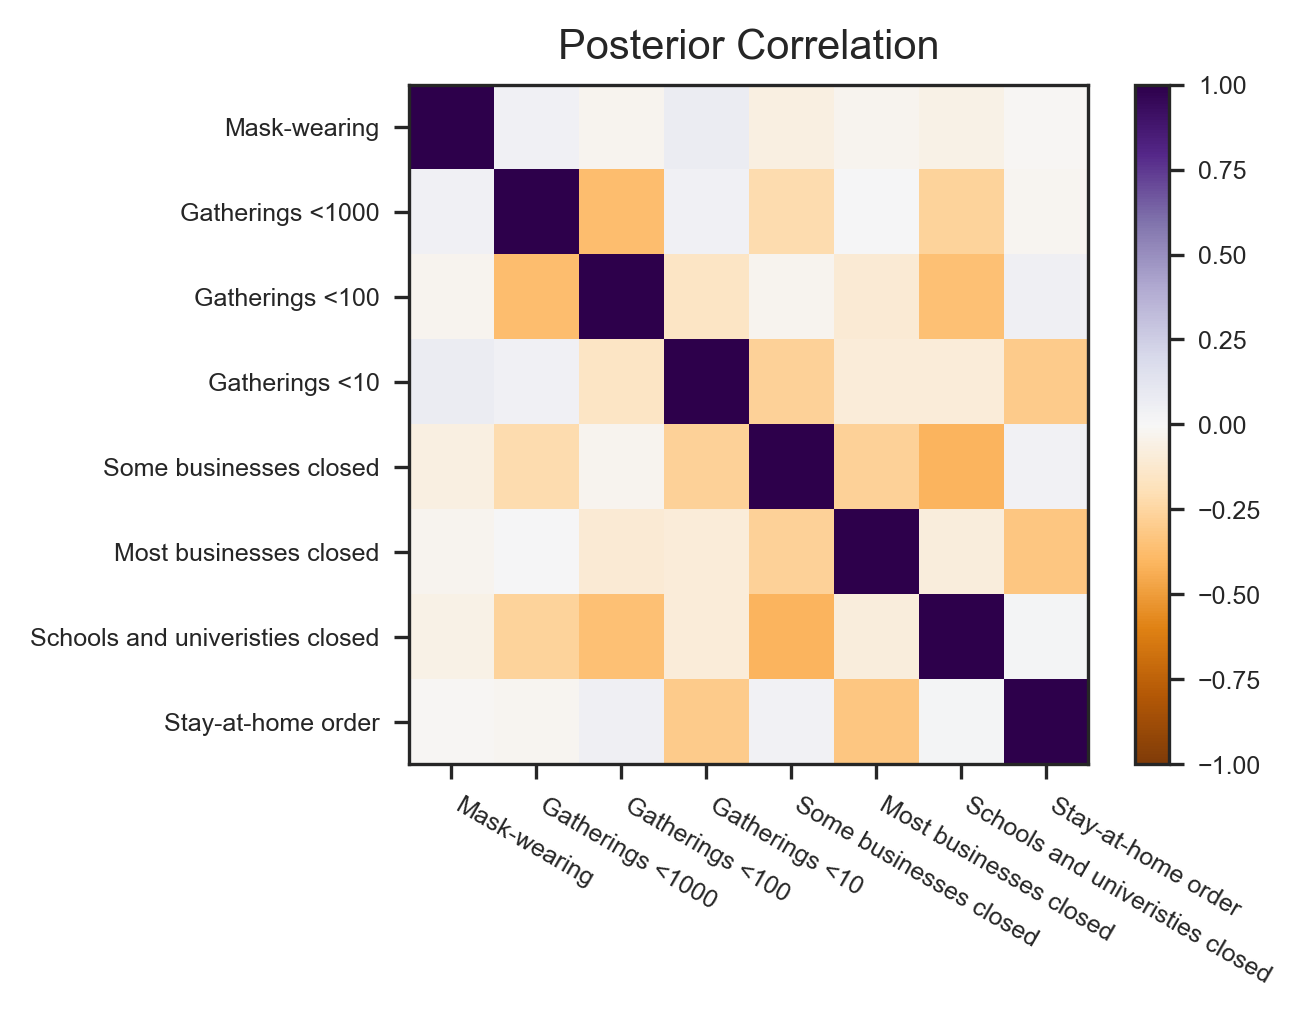

In [132]:
fig = plt.figure(figsize=(4, 3), dpi=300)
correlation = np.corrcoef(res, rowvar=False)
plt.imshow(correlation, cmap="PuOr", vmin=-1, vmax=1)
cbr = plt.colorbar()
cbr.ax.tick_params(labelsize=6)
plt.yticks(np.arange(N_cms), cms, fontsize=6)
plt.xticks(np.arange(N_cms), cms, fontsize=6, rotation=-30, ha="left")
plt.title("Posterior Correlation", fontsize=10);

plt.savefig(f"figs/main/FigureCorr.pdf", bbox_inches='tight')

In [128]:
np.min(correlation)

-0.4068607344188607

In [151]:
import arviz as az

In [165]:
ep = EpidemiologicalParameters()

In [166]:
ep.get_model_build_dict()

{'gi_mean_mean': 5.06,
 'gi_mean_sd': 0.3265,
 'gi_sd_mean': 2.11,
 'gi_sd_sd': 0.5,
 'deaths_delay_mean_mean': 21.819649695284962,
 'deaths_delay_mean_sd': 1.0056755718977664,
 'deaths_delay_disp_mean': 14.26238141720708,
 'deaths_delay_disp_sd': 5.177442947725441,
 'cases_delay_mean_mean': 10.92830227448381,
 'cases_delay_mean_sd': 0.9387435298564465,
 'cases_delay_disp_mean': 5.406593726647138,
 'cases_delay_disp_sd': 0.2689502951493133}

In [175]:
import scipy.stats as stats

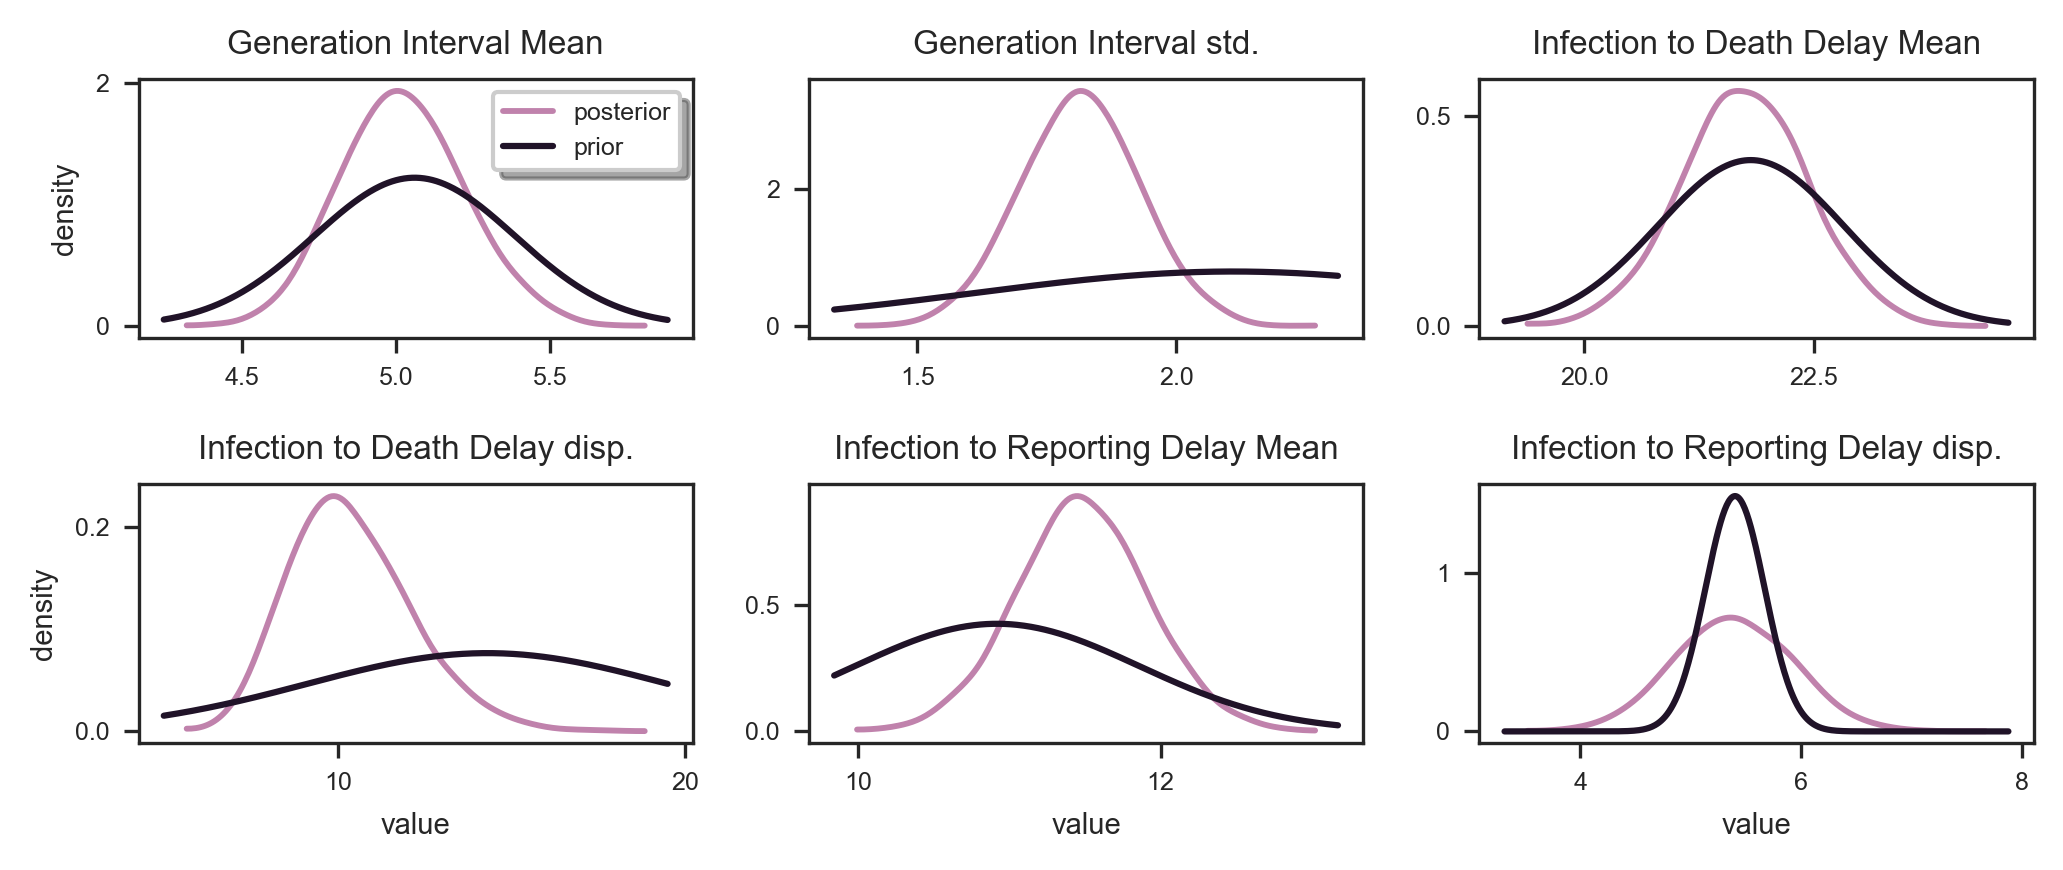

In [198]:
varnames = ["GI_mean", "GI_sd", "DeathsDelayMean", "DeathsDelayDisp", "CasesDelayMean", "CasesDelayDisp"]
titles = ['Generation Interval Mean', 'Generation Interval std.', 
          'Infection to Death Delay Mean', 'Infection to Death Delay disp.',
          'Infection to Reporting Delay Mean', 'Infection to Reporting Delay disp.']

prior_means = [5.06, 2.11, 21.81, 14.3, 10.92, 5.4]
prior_stds = [0.3265, 0.5, 1.01, 5.2, 0.94,  0.269]
plt.figure(figsize=(7, 3), dpi=300)
for v_i, v in enumerate(varnames):
    plt.subplot(2, 3, v_i + 1)
    az.plot_kde(trace[v], plot_kwargs={'color':cols[0]}, label='posterior')
    plt.title(titles[v_i], fontsize=8)
    
    l, u = plt.xlim()
    x = np.linspace(l, u, 500)
    d = stats.norm(loc=prior_means[v_i], scale=prior_stds[v_i])
    p = d.pdf(x)
    plt.plot(x, p, label='prior', color=cols[2])
    
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    if v_i == 0 or v_i == 3:
        plt.ylabel('density', fontsize=7)
    
    if v_i > 2:
        plt.xlabel('value', fontsize=7)
                
    if v_i == 0:
        plt.legend(fontsize=6, fancybox=True, shadow=True)
    else:
        plt.gca().get_legend().remove()

plt.tight_layout()
plt.savefig(f"figs/main/FigureParams.pdf", bbox_inches='tight')

# diagonostic plots

In [ ]:
import arviz as az

In [ ]:
ess = az.ess(trace)

In [ ]:
rhat = az.rhat(trace)

In [ ]:
trace.varnames

In [ ]:
def collate(stat):
    stat_all = []
    stat_nums = []
    for var in ["CMReduction", "GI_mean", "GI_sd", "GrowthCasesNoise", "GrowthDeathsNoise", "CasesDelayMean", "CasesDelayDisp",
                "InitialSizeDeaths_log", "InitialSizeCases_log", "DeathsDelayMean", "DeathsDelayDisp", "HyperRVar", "PsiCases",
                "PsiDeaths", "InfectedDeaths", "InfectedCases", "ExpectedDeaths", "ExpectedCases"]:
        if stat[str(var)].size>1:
            stat_all.append(stat[str(var)].to_dataframe().to_numpy().flatten())
        else:
            stat_nums.append(float(stat[str(var)]))
    stat_all = np.concatenate(np.array(stat_all))
    stat_all = np.concatenate([stat_all, stat_nums])
#     stat_all[stat_all > 100] = 1
    return stat_all

In [ ]:
ess

In [ ]:
plt.figure(figsize=(7, 3), dpi=300)
plt.subplot(121)
plt.hist(collate(rhat), bins=40)
plt.title("$\hat{R}$", fontsize=12)

plt.subplot(122)
plt.hist(collate(ess)/8000, bins=40)
plt.xlim([0, 2.5])
plt.title("ESS", fontsize=12)
plt.savefig(f"figs/main/FigureMCMCStats.pdf", bbox_inches='tight')

# Model Fit Graphs

In [216]:
def epicurve_plot(region, start_d_i=30):
    r_i = data.Rs.index(region)
    
    if len(np.nonzero(data.NewCases.mask[r_i, :])[0]) > 0:
        end_d_i = np.nonzero(data.NewCases.mask[r_i, :])[0][0]+3
    else:
        end_d_i = len(data.Ds)

    ec = trace.ExpectedDeaths[:, r_i]
    nS, nDs = ec.shape

    try:
        dist = pm.NegativeBinomial.dist(mu=ec, alpha=np.repeat(trace.PsiDeaths.reshape((nS, 1)), nDs, axis=-1))
        ec_output = dist.random()
    except ValueError:
        ec_output = 0 * ec
        means_d = means_d * 0
        lu_id = lu_id * 0
        up_id = up_id * 0

    means_expected_deaths, lu_ed, up_ed, _, _ = produce_CIs(
        ec_output
    )

    eco = trace.ExpectedCases[:, r_i]
    nS, nDs = eco.shape

    try:
        dist = pm.NegativeBinomial.dist(mu=eco, alpha=np.repeat(trace.PsiCases.reshape((nS, 1)), nDs, axis=-1))
        eco_output = dist.random()
    except ValueError:
        eco_output = 10**-10 * ec

    means_expected_cases, lu_ec, up_ec, _, _ = produce_CIs(
        eco_output
    )

    days = data.Ds
    days_x = np.arange(len(days))
    deaths = data.NewDeaths[r_i, :]
    cases = data.NewCases[r_i, :]

    ax = plt.gca()
    
    plt.plot(
        days_x,
        means_expected_deaths,
        label="Predicted Daily Deaths",
        zorder=2,
        color="tab:red"
    )

    plt.fill_between(
        days_x, lu_ed, up_ed, alpha=0.25, color="tab:red", linewidth=0
    )

    plt.scatter(
        days_x,
        deaths,
        label="Recorded Daily Deaths",
        marker="o",
        s=10,
        color="tab:red",
        alpha=0.9,
        zorder=3,
    )
    
    plt.plot(
        days_x,
        means_expected_cases,
        label="Predicted Daily Confirmed Cases",
        zorder=2,
        color="tab:blue"
    )

    plt.fill_between(
        days_x, lu_ec, up_ec, alpha=0.25, color="tab:blue", linewidth=0
    )

    plt.scatter(
        days_x,
        cases,
        label="Recorded Daily Confirmed Cases",
        marker="o",
        s=10,
        color="tab:blue",
        alpha=0.9,
        zorder=3,
    )

    ax.set_yscale("log")
    plt.ylim([10 ** 0, 10 ** 6])
    locs = np.arange(start_d_i, end_d_i, 14)
    xlabels = [f"{data.Ds[ts].day}-{month_to_str(data.Ds[ts].month)}" for ts in locs]
    plt.xticks(locs, xlabels, rotation=-30, ha="left")
    plt.xlim((start_d_i, end_d_i))
    
    ax=plt.gca()
    add_cms_to_plot(ax, data.ActiveCMs, r_i, start_d_i, end_d_i, data.Ds, cm_plot_style)
    plt.title(data.RNames[region][0], fontsize=12)
    
    return ax
    
def reprod_plot(r, start_d_i=30):
    r_i = data.Rs.index(r)
    
    nS, nCMs = trace.CM_Alpha.shape
    nDs = len(data.Ds)
    
    
    ActiveCMRed = np.sum(data.ActiveCMs[r_i, :, : ].reshape((1, nCMs, nDs)) * trace.CM_Alpha.reshape((nS, nCMs, 1)), axis=1)    
    RegionR = trace['RegionR'][:, r_i]

    rs = np.exp(np.log(RegionR.reshape((nS, 1))) - ActiveCMRed)
    
    if len(np.nonzero(data.NewCases.mask[r_i, :])[0]) > 0:
        end_d_i = np.nonzero(data.NewCases.mask[r_i, :])[0][0]+3
    else:
        end_d_i = len(data.Ds)
    
    days_x = np.arange(len(data.Ds))
    
    
    mns, lu, up, _, _ = produce_CIs(
        rs
    )
    
    plt.plot(days_x, mns, color="tab:grey")
    plt.fill_between(
        days_x, lu, up, alpha=0.25, color="tab:grey", linewidth=0
    )
    
    locs = np.arange(start_d_i, end_d_i, 14)
    xlabels = [f"{data.Ds[ts].day}-{month_to_str(data.Ds[ts].month)}" for ts in locs]
    plt.xticks(locs, xlabels, rotation=-30, ha="left")
    plt.xlim((start_d_i, end_d_i))
    plt.ylim([0, 5])
    plt.plot([start_d_i, end_d_i], [1, 1], color="k")
    plt.ylabel("$R_t$", fontsize=10)
    ax=plt.gca()
    add_cms_to_plot(ax, data.ActiveCMs, r_i, start_d_i, end_d_i, data.Ds, cm_plot_style)
    plt.title(data.RNames[r][0], fontsize=12)
    
def month_to_str(x):
    if x == 1:
        return "JAN"
    if x == 2:
        return "FEB"
    if x == 3:
        return "MAR"
    if x == 4:
        return "APR"
    if x == 5:
        return "MAY"
    

'Font Awesome 5 Free-Solid-900.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


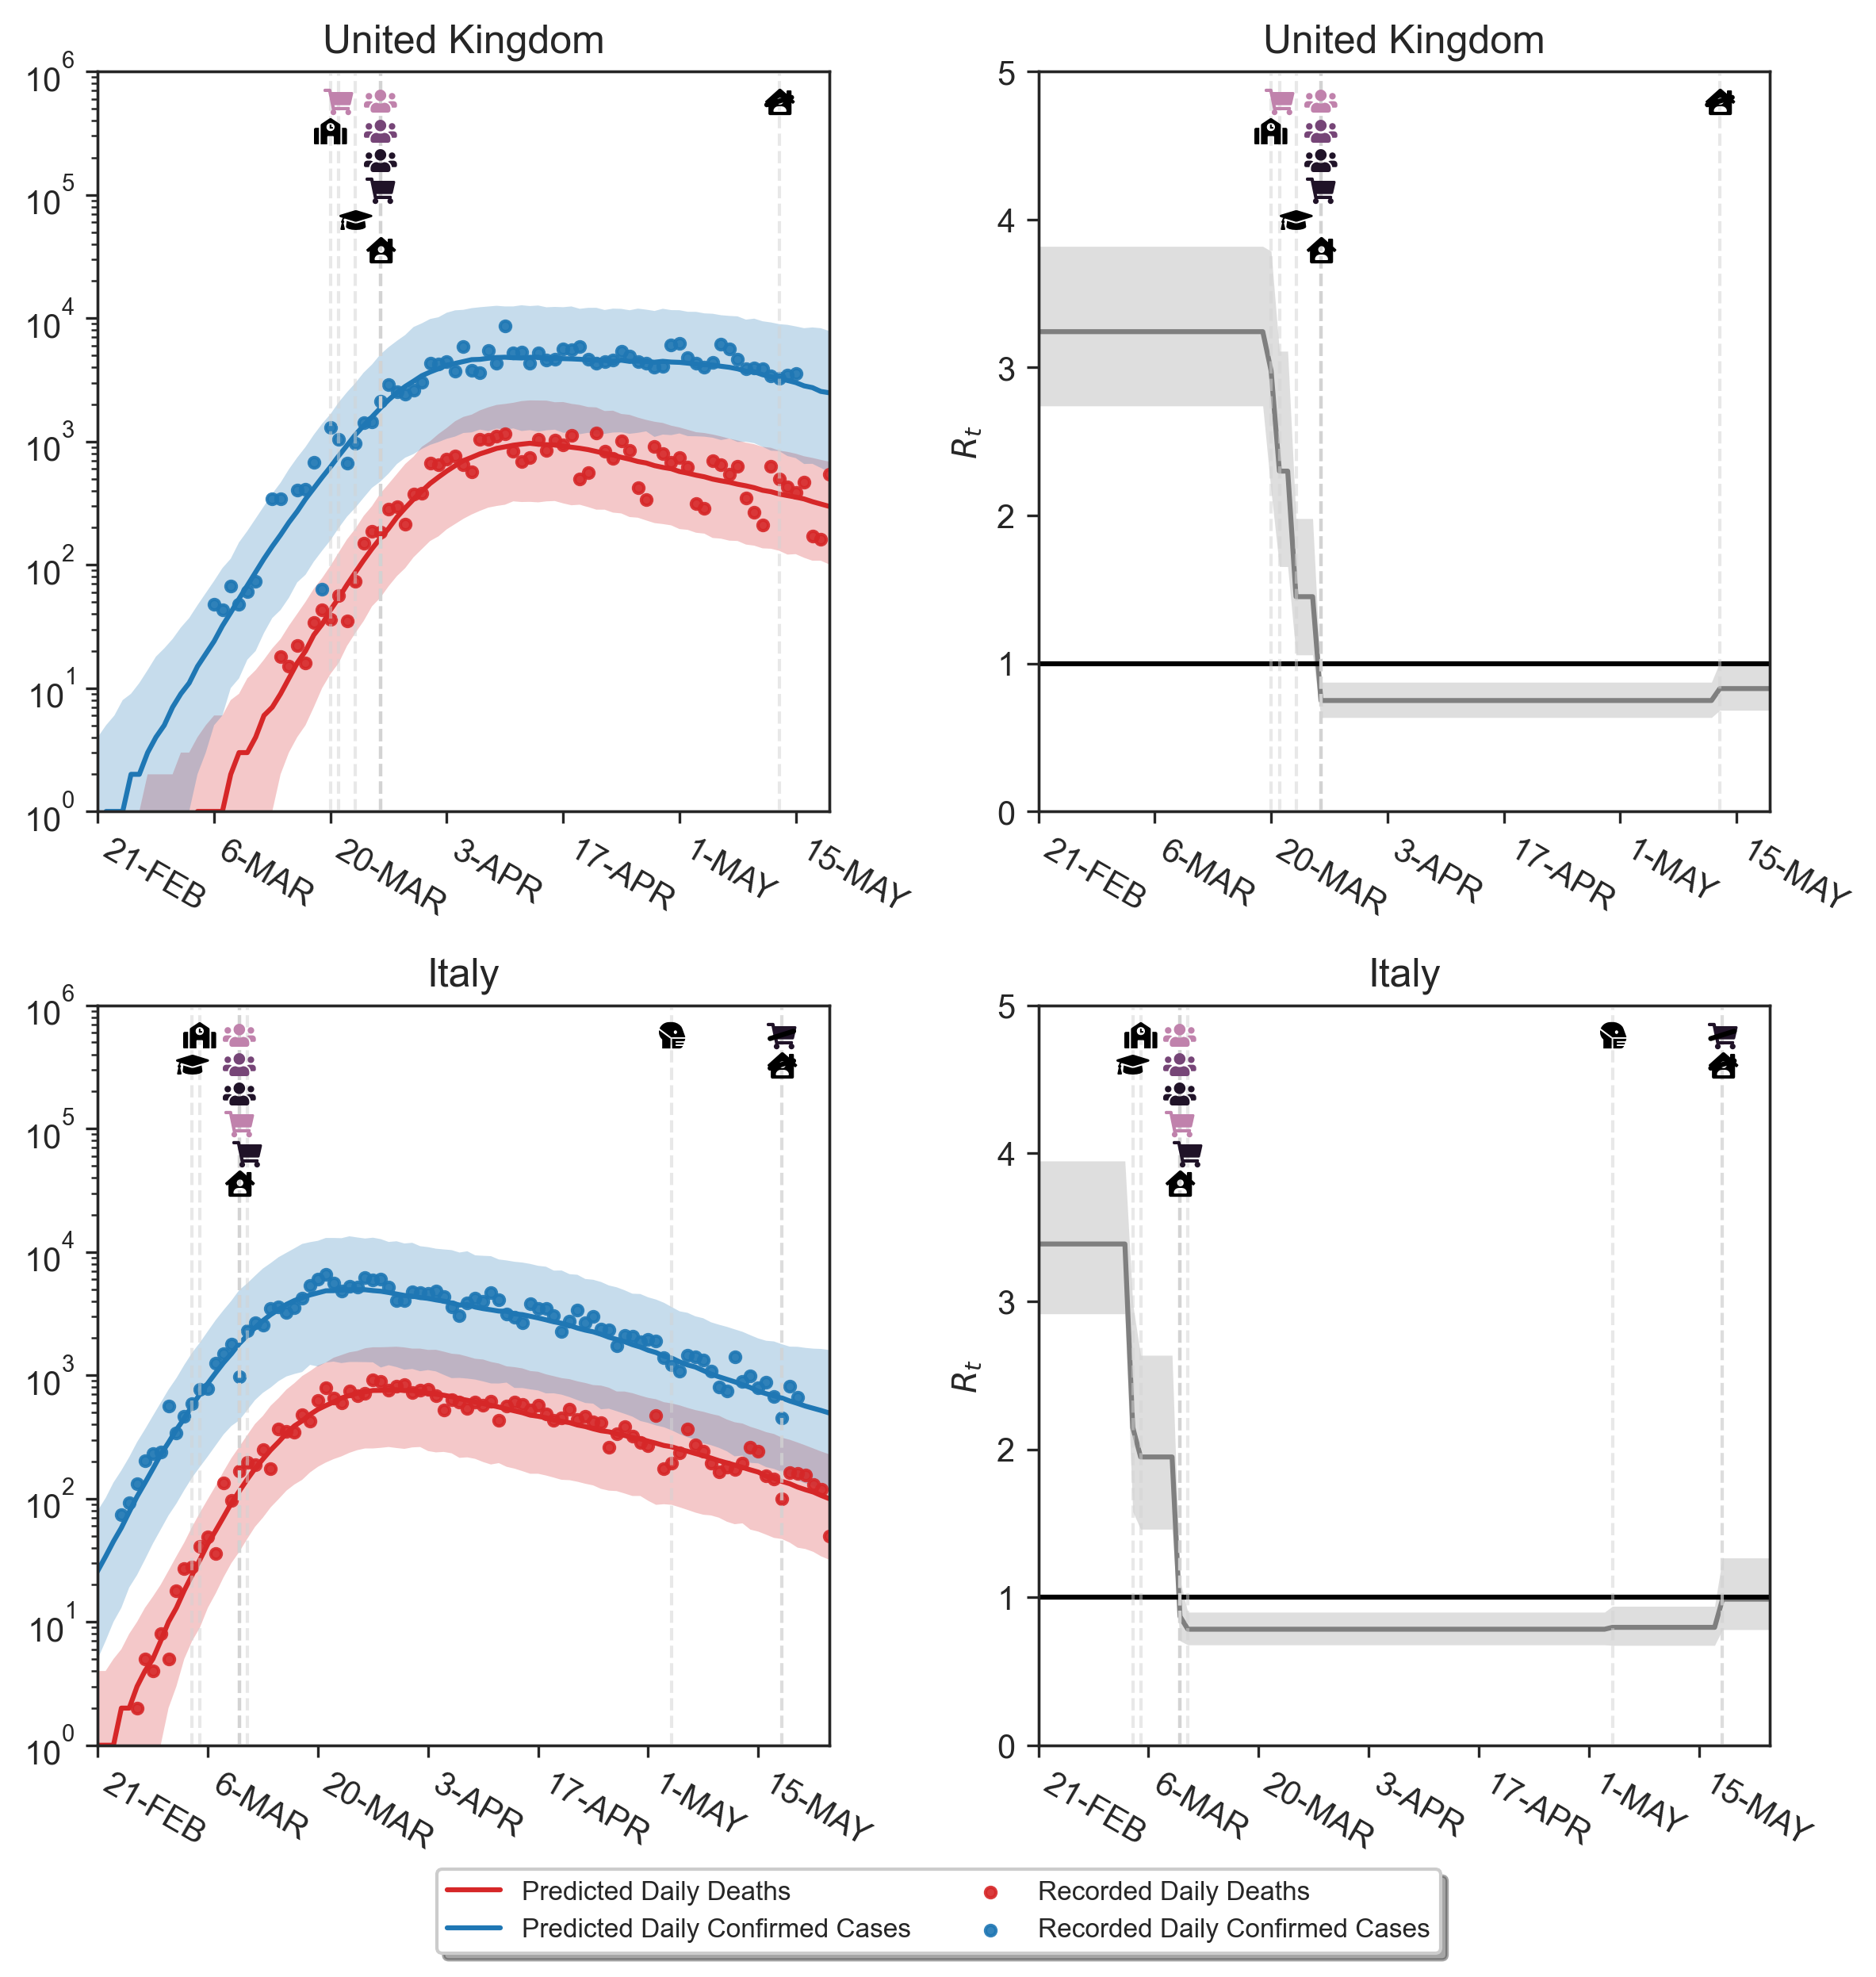

In [218]:
import pymc3 as pm

rs = ["GB", "IT"]
plt.figure(figsize=(8, 8), dpi=300)

plt.subplot(221)
epicurve_plot(rs[0])

plt.subplot(222)
reprod_plot(rs[0])

plt.subplot(223)
ax = epicurve_plot(rs[1])

plt.subplot(224)
reprod_plot(rs[1])


plt.tight_layout()


ax.legend(shadow=True, fancybox=True, loc = "upper center", bbox_to_anchor = (1.15, -0.15), fontsize=8, ncol=2)

plt.savefig(f"figs/main/FigFits.pdf", bbox_inches='tight')

# Conditioning Videos

In [ ]:
def condition_on(results, cm_index, value):
    copy_res = copy.deepcopy(results)
    remaining_res = np.delete(copy_res, cm_index, axis=1)
    
    cms = np.arange(8)

    cms_remaining = np.delete(cms, cm_index)
    res_mat = np.zeros((nS, nCMs))
    res_mat[:, -1] = copy_res[:, cm_index]
    res_mat[:, :-1] = remaining_res 
    
    mu = np.mean(100*(1-res_mat), axis=0)
    cov = np.cov(100*(1-res_mat), rowvar=False)
    
    m_1 = mu[:nCMs-1]
    m_2 = mu[-1]
    s_11 = cov[:nCMs-1, :nCMs-1]
    s_12 = cov[:nCMs-1, -1]
    s_22 = cov[-1, -1]
    
    mu_bar = m_1 + s_12 * (s_22**-1) * (value - m_2)
    sigma_bar = s_11 - (1/s_22) * s_12 @ s_12.T
    
    low = mu_bar - 2*np.diag(sigma_bar)**0.5
    high = mu_bar + 2*np.diag(sigma_bar)**0.5
    
    return (mu_bar, low, high, cms_remaining.tolist())

In [ ]:
np.mean(res, axis=0)

In [ ]:
CMs = ['Mask-wearing',
 'Gatherings <1000',
 'Gatherings <100',
 'Gatherings <10',
 'Some businesses closed',
 'Most businesses closed',
 'Schools and universities closed',
 'Stay-at-home order']

nCMs = len(CMs) 

In [ ]:
from IPython.display import HTML
import matplotlib.animation as animation
import copy 

for i in range(8):
    fig = plt.figure(figsize=(6, 3), dpi=300)
    x_min = -50
    x_max = 100
    plt.plot([0, 0], [1, -(nCMs)], "--k", linewidth=0.5)
    xrange = np.array([x_min, x_max])
    for height in range(0, nCMs+2, 2):
        plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.5, linewidth=0)
    xtick_vals = [-50, -25, 0, 25, 50, 75, 100]
    xtick_str = [f"{x:.0f}%" for x in xtick_vals]
    plt.yticks([])

    x_r = np.abs(x_min - x_max)
    plt.xticks(xtick_vals, xtick_str, fontsize=8)
    plt.xlim([x_min, x_max])
    plt.ylim([-(nCMs - 0.25), 0.75])

    lines = []
    mu = np.mean(100*(1-res), axis=0)
    stds = np.diag(np.cov(100*(1-res), rowvar=False))**0.5

    for cm in range(nCMs): 
        line, = plt.gca().plot([mu[cm] - 2*stds[cm], mu[cm] + 2*stds[cm]], [-cm, -cm], color="black", alpha=0.25)
        line2, = plt.gca().plot([mu[cm] , mu[cm]], [-cm-0.1, -cm+0.1], color="black")
        lines.append((line, line2))

    plt.yticks(-np.arange(nCMs), CMs, fontsize=8)
    yticklabels = plt.gca().yaxis.get_ticklabels()
    yticklabels[i].set_color("tab:red")
    plt.text(50, 0, "Note: this video shows the\nadditional effect, and not the\ncumulative effect of each NPI.", fontsize=6, va="center", weight="bold")   


    def animate(i, which_cm, n_frames):
        val = mu[which_cm] + (2*stds[which_cm] * 2*float(i)/n_frames) - 2*stds[which_cm]
        lines[which_cm][0].set_xdata([-200, -200])
        lines[which_cm][1].set_xdata([val, val])
        lines[which_cm][1].set_color("tab:red")
        plt.title(f"Approximate Posterior Conditional on {CMs[which_cm]}", fontsize=10)

        mu_bar, low, high, cms_remaining = condition_on(res, which_cm, val)
        for i, cm in enumerate(cms_remaining):
            lines[cm][0].set_xdata([low[i], high[i]])
            lines[cm][1].set_xdata([mu_bar[i], mu_bar[i]])
        plt.tight_layout()

    anim = animation.FuncAnimation(fig, animate, frames=100, interval=50, fargs=(i, 100, ));
    HTML(anim.to_jshtml())

In [ ]:
fig = plt.figure(figsize=(6, 3), dpi=300)

x_min = -50
x_max = 100
plt.plot([0, 0], [1, -(nCMs)], "--k", linewidth=0.5)
xrange = np.array([x_min, x_max])
for height in range(0, nCMs+2, 2):
    plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.5, linewidth=0)
xtick_vals = [-50, -25, 0, 25, 50, 75, 100]
xtick_str = [f"{x:.0f}%" for x in xtick_vals]
plt.yticks([])

x_r = np.abs(x_min - x_max)
plt.xticks(xtick_vals, xtick_str, fontsize=8)
plt.xlim([x_min, x_max])
plt.ylim([-(nCMs - 0.25), 0.75])

lines = []
mu = np.mean(100*(1-res), axis=0)
stds = np.diag(np.cov(100*(1-res), rowvar=False))**0.5

for cm in range(nCMs): 
    line, = plt.gca().plot([mu[cm] - 2*stds[cm], mu[cm] + 2*stds[cm]], [-cm, -cm], color="black", alpha=0.25)
    line2, = plt.gca().plot([mu[cm] , mu[cm]], [-cm-0.1, -cm+0.1], color="black")
    lines.append((line, line2))

plt.yticks(-np.arange(nCMs), CMs, fontsize=8)
yticklabels = plt.gca().yaxis.get_ticklabels()
yticklabels[7].set_color("tab:red")
plt.text(50, 0, "Note: this video shows the\nadditional effect, and not the\ncumulative effect of each NPI.", fontsize=6, va="center", weight="bold")   

    
def animate(i, which_cm, n_frames):
    val = mu[which_cm] + (2*stds[which_cm] * 2*float(i)/n_frames) - 2*stds[which_cm]
    lines[which_cm][0].set_xdata([-200, -200])
    lines[which_cm][1].set_xdata([val, val])
    lines[which_cm][1].set_color("tab:red")
    plt.title(f"Approximate Posterior Conditional on {CMs[which_cm]}", fontsize=10)
    
    mu_bar, low, high, cms_remaining = condition_on(res, which_cm, val)
    for i, cm in enumerate(cms_remaining):
        lines[cm][0].set_xdata([low[i], high[i]])
        lines[cm][1].set_xdata([mu_bar[i], mu_bar[i]])
    plt.tight_layout()
    
anim = animation.FuncAnimation(fig, animate, frames=100, interval=50, fargs=(7, 100, ));
HTML(anim.to_jshtml())

In [ ]:
npi = 0

fig = plt.figure(figsize=(6, 3), dpi=300)

x_min = -50
x_max = 100
plt.plot([0, 0], [1, -(nCMs)], "--k", linewidth=0.5)
xrange = np.array([x_min, x_max])
for height in range(0, nCMs+2, 2):
    plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.5, linewidth=0)
xtick_vals = [-50, -25, 0, 25, 50, 75, 100]
xtick_str = [f"{x:.0f}%" for x in xtick_vals]
plt.yticks([])

x_r = np.abs(x_min - x_max)
plt.xticks(xtick_vals, xtick_str, fontsize=8)
plt.xlim([x_min, x_max])
plt.ylim([-(nCMs - 0.25), 0.75])

lines = []
mu = np.mean(100*(1-res), axis=0)
stds = np.diag(np.cov(100*(1-res), rowvar=False))**0.5

for cm in range(nCMs): 
    line, = plt.gca().plot([mu[cm] - 2*stds[cm], mu[cm] + 2*stds[cm]], [-cm, -cm], color="black", alpha=0.25)
    line2, = plt.gca().plot([mu[cm] , mu[cm]], [-cm-0.1, -cm+0.1], color="black")
    lines.append((line, line2))

plt.yticks(-np.arange(nCMs), CMs, fontsize=8)
yticklabels = plt.gca().yaxis.get_ticklabels()
yticklabels[npi].set_color("tab:red")
plt.text(50, 0, "Note: this video shows the\nadditional effect, and not the\ncumulative effect of each NPI.", fontsize=6, va="center", weight="bold")   

    
def animate(i, which_cm, n_frames):
    val = mu[which_cm] + (2*stds[which_cm] * 2*float(i)/n_frames) - 2*stds[which_cm]
    lines[which_cm][0].set_xdata([-200, -200])
    lines[which_cm][1].set_xdata([val, val])
    lines[which_cm][1].set_color("tab:red")
    plt.title(f"Approximate Posterior Conditional on {CMs[which_cm]}", fontsize=10)
    
    mu_bar, low, high, cms_remaining = condition_on(res, which_cm, val)
    for i, cm in enumerate(cms_remaining):
        lines[cm][0].set_xdata([low[i], high[i]])
        lines[cm][1].set_xdata([mu_bar[i], mu_bar[i]])
    plt.tight_layout()
    
anim = animation.FuncAnimation(fig, animate, frames=100, interval=50, fargs=(npi, 100, ));
HTML(anim.to_jshtml())

In [ ]:
npi = 1

fig = plt.figure(figsize=(6, 3), dpi=300)

x_min = -50
x_max = 100
plt.plot([0, 0], [1, -(nCMs)], "--k", linewidth=0.5)
xrange = np.array([x_min, x_max])
for height in range(0, nCMs+2, 2):
    plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.5, linewidth=0)
xtick_vals = [-50, -25, 0, 25, 50, 75, 100]
xtick_str = [f"{x:.0f}%" for x in xtick_vals]
plt.yticks([])

x_r = np.abs(x_min - x_max)
plt.xticks(xtick_vals, xtick_str, fontsize=8)
plt.xlim([x_min, x_max])
plt.ylim([-(nCMs - 0.25), 0.75])

lines = []
mu = np.mean(100*(1-res), axis=0)
stds = np.diag(np.cov(100*(1-res), rowvar=False))**0.5

for cm in range(nCMs): 
    line, = plt.gca().plot([mu[cm] - 2*stds[cm], mu[cm] + 2*stds[cm]], [-cm, -cm], color="black", alpha=0.25)
    line2, = plt.gca().plot([mu[cm] , mu[cm]], [-cm-0.1, -cm+0.1], color="black")
    lines.append((line, line2))

plt.yticks(-np.arange(nCMs), CMs, fontsize=8)
yticklabels = plt.gca().yaxis.get_ticklabels()
yticklabels[npi].set_color("tab:red")
plt.text(50, 0, "Note: this video shows the\nadditional effect, and not the\ncumulative effect of each NPI.", fontsize=6, va="center", weight="bold")   

    
def animate(i, which_cm, n_frames):
    val = mu[which_cm] + (2*stds[which_cm] * 2*float(i)/n_frames) - 2*stds[which_cm]
    lines[which_cm][0].set_xdata([-200, -200])
    lines[which_cm][1].set_xdata([val, val])
    lines[which_cm][1].set_color("tab:red")
    plt.title(f"Approximate Posterior Conditional on {CMs[which_cm]}", fontsize=10)
    
    mu_bar, low, high, cms_remaining = condition_on(res, which_cm, val)
    for i, cm in enumerate(cms_remaining):
        lines[cm][0].set_xdata([low[i], high[i]])
        lines[cm][1].set_xdata([mu_bar[i], mu_bar[i]])
    plt.tight_layout()
    
anim = animation.FuncAnimation(fig, animate, frames=100, interval=50, fargs=(npi, 100, ));
HTML(anim.to_jshtml())

In [ ]:
npi = 2

fig = plt.figure(figsize=(6, 3), dpi=300)

x_min = -50
x_max = 100
plt.plot([0, 0], [1, -(nCMs)], "--k", linewidth=0.5)
xrange = np.array([x_min, x_max])
for height in range(0, nCMs+2, 2):
    plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.5, linewidth=0)
xtick_vals = [-50, -25, 0, 25, 50, 75, 100]
xtick_str = [f"{x:.0f}%" for x in xtick_vals]
plt.yticks([])

x_r = np.abs(x_min - x_max)
plt.xticks(xtick_vals, xtick_str, fontsize=8)
plt.xlim([x_min, x_max])
plt.ylim([-(nCMs - 0.25), 0.75])

lines = []
mu = np.mean(100*(1-res), axis=0)
stds = np.diag(np.cov(100*(1-res), rowvar=False))**0.5

for cm in range(nCMs): 
    line, = plt.gca().plot([mu[cm] - 2*stds[cm], mu[cm] + 2*stds[cm]], [-cm, -cm], color="black", alpha=0.25)
    line2, = plt.gca().plot([mu[cm] , mu[cm]], [-cm-0.1, -cm+0.1], color="black")
    lines.append((line, line2))

plt.yticks(-np.arange(nCMs), CMs, fontsize=8)
yticklabels = plt.gca().yaxis.get_ticklabels()
yticklabels[npi].set_color("tab:red")
plt.text(50, 0, "Note: this video shows the\nadditional effect, and not the\ncumulative effect of each NPI.", fontsize=6, va="center", weight="bold")   

    
def animate(i, which_cm, n_frames):
    val = mu[which_cm] + (2*stds[which_cm] * 2*float(i)/n_frames) - 2*stds[which_cm]
    lines[which_cm][0].set_xdata([-200, -200])
    lines[which_cm][1].set_xdata([val, val])
    lines[which_cm][1].set_color("tab:red")
    plt.title(f"Approximate Posterior Conditional on {CMs[which_cm]}", fontsize=10)
    
    mu_bar, low, high, cms_remaining = condition_on(res, which_cm, val)
    for i, cm in enumerate(cms_remaining):
        lines[cm][0].set_xdata([low[i], high[i]])
        lines[cm][1].set_xdata([mu_bar[i], mu_bar[i]])
    plt.tight_layout()
    
anim = animation.FuncAnimation(fig, animate, frames=100, interval=50, fargs=(npi, 100, ));
HTML(anim.to_jshtml())

In [ ]:
npi = 3

fig = plt.figure(figsize=(6, 3), dpi=300)

x_min = -50
x_max = 100
plt.plot([0, 0], [1, -(nCMs)], "--k", linewidth=0.5)
xrange = np.array([x_min, x_max])
for height in range(0, nCMs+2, 2):
    plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.5, linewidth=0)
xtick_vals = [-50, -25, 0, 25, 50, 75, 100]
xtick_str = [f"{x:.0f}%" for x in xtick_vals]
plt.yticks([])

x_r = np.abs(x_min - x_max)
plt.xticks(xtick_vals, xtick_str, fontsize=8)
plt.xlim([x_min, x_max])
plt.ylim([-(nCMs - 0.25), 0.75])

lines = []
mu = np.mean(100*(1-res), axis=0)
stds = np.diag(np.cov(100*(1-res), rowvar=False))**0.5

for cm in range(nCMs): 
    line, = plt.gca().plot([mu[cm] - 2*stds[cm], mu[cm] + 2*stds[cm]], [-cm, -cm], color="black", alpha=0.25)
    line2, = plt.gca().plot([mu[cm] , mu[cm]], [-cm-0.1, -cm+0.1], color="black")
    lines.append((line, line2))

plt.yticks(-np.arange(nCMs), CMs, fontsize=8)
yticklabels = plt.gca().yaxis.get_ticklabels()
yticklabels[npi].set_color("tab:red")
plt.text(50, 0, "Note: this video shows the\nadditional effect, and not the\ncumulative effect of each NPI.", fontsize=6, va="center", weight="bold")   

    
def animate(i, which_cm, n_frames):
    val = mu[which_cm] + (2*stds[which_cm] * 2*float(i)/n_frames) - 2*stds[which_cm]
    lines[which_cm][0].set_xdata([-200, -200])
    lines[which_cm][1].set_xdata([val, val])
    lines[which_cm][1].set_color("tab:red")
    plt.title(f"Approximate Posterior Conditional on {CMs[which_cm]}", fontsize=10)
    
    mu_bar, low, high, cms_remaining = condition_on(res, which_cm, val)
    for i, cm in enumerate(cms_remaining):
        lines[cm][0].set_xdata([low[i], high[i]])
        lines[cm][1].set_xdata([mu_bar[i], mu_bar[i]])
    plt.tight_layout()
    
anim = animation.FuncAnimation(fig, animate, frames=100, interval=50, fargs=(npi, 100, ));
HTML(anim.to_jshtml())

In [ ]:
npi = 4

fig = plt.figure(figsize=(6, 3), dpi=300)

x_min = -50
x_max = 100
plt.plot([0, 0], [1, -(nCMs)], "--k", linewidth=0.5)
xrange = np.array([x_min, x_max])
for height in range(0, nCMs+2, 2):
    plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.5, linewidth=0)
xtick_vals = [-50, -25, 0, 25, 50, 75, 100]
xtick_str = [f"{x:.0f}%" for x in xtick_vals]
plt.yticks([])

x_r = np.abs(x_min - x_max)
plt.xticks(xtick_vals, xtick_str, fontsize=8)
plt.xlim([x_min, x_max])
plt.ylim([-(nCMs - 0.25), 0.75])

lines = []
mu = np.mean(100*(1-res), axis=0)
stds = np.diag(np.cov(100*(1-res), rowvar=False))**0.5

for cm in range(nCMs): 
    line, = plt.gca().plot([mu[cm] - 2*stds[cm], mu[cm] + 2*stds[cm]], [-cm, -cm], color="black", alpha=0.25)
    line2, = plt.gca().plot([mu[cm] , mu[cm]], [-cm-0.1, -cm+0.1], color="black")
    lines.append((line, line2))

plt.yticks(-np.arange(nCMs), CMs, fontsize=8)
yticklabels = plt.gca().yaxis.get_ticklabels()
yticklabels[npi].set_color("tab:red")
plt.text(50, 0, "Note: this video shows the\nadditional effect, and not the\ncumulative effect of each NPI.", fontsize=6, va="center", weight="bold")   

    
def animate(i, which_cm, n_frames):
    val = mu[which_cm] + (2*stds[which_cm] * 2*float(i)/n_frames) - 2*stds[which_cm]
    lines[which_cm][0].set_xdata([-200, -200])
    lines[which_cm][1].set_xdata([val, val])
    lines[which_cm][1].set_color("tab:red")
    plt.title(f"Approximate Posterior Conditional on {CMs[which_cm]}", fontsize=10)
    
    mu_bar, low, high, cms_remaining = condition_on(res, which_cm, val)
    for i, cm in enumerate(cms_remaining):
        lines[cm][0].set_xdata([low[i], high[i]])
        lines[cm][1].set_xdata([mu_bar[i], mu_bar[i]])
    plt.tight_layout()
    
anim = animation.FuncAnimation(fig, animate, frames=100, interval=50, fargs=(npi, 100, ));
HTML(anim.to_jshtml())

In [ ]:
npi = 5

fig = plt.figure(figsize=(6, 3), dpi=300)

x_min = -50
x_max = 100
plt.plot([0, 0], [1, -(nCMs)], "--k", linewidth=0.5)
xrange = np.array([x_min, x_max])
for height in range(0, nCMs+2, 2):
    plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.5, linewidth=0)
xtick_vals = [-50, -25, 0, 25, 50, 75, 100]
xtick_str = [f"{x:.0f}%" for x in xtick_vals]
plt.yticks([])

x_r = np.abs(x_min - x_max)
plt.xticks(xtick_vals, xtick_str, fontsize=8)
plt.xlim([x_min, x_max])
plt.ylim([-(nCMs - 0.25), 0.75])

lines = []
mu = np.mean(100*(1-res), axis=0)
stds = np.diag(np.cov(100*(1-res), rowvar=False))**0.5

for cm in range(nCMs): 
    line, = plt.gca().plot([mu[cm] - 2*stds[cm], mu[cm] + 2*stds[cm]], [-cm, -cm], color="black", alpha=0.25)
    line2, = plt.gca().plot([mu[cm] , mu[cm]], [-cm-0.1, -cm+0.1], color="black")
    lines.append((line, line2))

plt.yticks(-np.arange(nCMs), CMs, fontsize=8)
yticklabels = plt.gca().yaxis.get_ticklabels()
yticklabels[npi].set_color("tab:red")
plt.text(50, 0, "Note: this video shows the\nadditional effect, and not the\ncumulative effect of each NPI.", fontsize=6, va="center", weight="bold")   

    
def animate(i, which_cm, n_frames):
    val = mu[which_cm] + (2*stds[which_cm] * 2*float(i)/n_frames) - 2*stds[which_cm]
    lines[which_cm][0].set_xdata([-200, -200])
    lines[which_cm][1].set_xdata([val, val])
    lines[which_cm][1].set_color("tab:red")
    plt.title(f"Approximate Posterior Conditional on {CMs[which_cm]}", fontsize=10)
    
    mu_bar, low, high, cms_remaining = condition_on(res, which_cm, val)
    for i, cm in enumerate(cms_remaining):
        lines[cm][0].set_xdata([low[i], high[i]])
        lines[cm][1].set_xdata([mu_bar[i], mu_bar[i]])
    plt.tight_layout()
    
anim = animation.FuncAnimation(fig, animate, frames=100, interval=50, fargs=(npi, 100, ));
HTML(anim.to_jshtml())

In [ ]:
npi = 6

fig = plt.figure(figsize=(6, 3), dpi=300)

x_min = -50
x_max = 100
plt.plot([0, 0], [1, -(nCMs)], "--k", linewidth=0.5)
xrange = np.array([x_min, x_max])
for height in range(0, nCMs+2, 2):
    plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.5, linewidth=0)
xtick_vals = [-50, -25, 0, 25, 50, 75, 100]
xtick_str = [f"{x:.0f}%" for x in xtick_vals]
plt.yticks([])

x_r = np.abs(x_min - x_max)
plt.xticks(xtick_vals, xtick_str, fontsize=8)
plt.xlim([x_min, x_max])
plt.ylim([-(nCMs - 0.25), 0.75])

lines = []
mu = np.mean(100*(1-res), axis=0)
stds = np.diag(np.cov(100*(1-res), rowvar=False))**0.5

for cm in range(nCMs): 
    line, = plt.gca().plot([mu[cm] - 2*stds[cm], mu[cm] + 2*stds[cm]], [-cm, -cm], color="black", alpha=0.25)
    line2, = plt.gca().plot([mu[cm] , mu[cm]], [-cm-0.1, -cm+0.1], color="black")
    lines.append((line, line2))

plt.yticks(-np.arange(nCMs), CMs, fontsize=8)
yticklabels = plt.gca().yaxis.get_ticklabels()
yticklabels[npi].set_color("tab:red")
plt.text(50, 0, "Note: this video shows the\nadditional effect, and not the\ncumulative effect of each NPI.", fontsize=6, va="center", weight="bold")   

    
def animate(i, which_cm, n_frames):
    val = mu[which_cm] + (2*stds[which_cm] * 2*float(i)/n_frames) - 2*stds[which_cm]
    lines[which_cm][0].set_xdata([-200, -200])
    lines[which_cm][1].set_xdata([val, val])
    lines[which_cm][1].set_color("tab:red")
    plt.title(f"Approximate Posterior Conditional on {CMs[which_cm]}", fontsize=10)
    
    mu_bar, low, high, cms_remaining = condition_on(res, which_cm, val)
    for i, cm in enumerate(cms_remaining):
        lines[cm][0].set_xdata([low[i], high[i]])
        lines[cm][1].set_xdata([mu_bar[i], mu_bar[i]])
    plt.tight_layout()
    
anim = animation.FuncAnimation(fig, animate, frames=100, interval=50, fargs=(npi, 100, ));
HTML(anim.to_jshtml())

In [ ]:
npi = 7

fig = plt.figure(figsize=(6, 3), dpi=300)

x_min = -50
x_max = 100
plt.plot([0, 0], [1, -(nCMs)], "--k", linewidth=0.5)
xrange = np.array([x_min, x_max])
for height in range(0, nCMs+2, 2):
    plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.5, linewidth=0)
xtick_vals = [-50, -25, 0, 25, 50, 75, 100]
xtick_str = [f"{x:.0f}%" for x in xtick_vals]
plt.yticks([])

x_r = np.abs(x_min - x_max)
plt.xticks(xtick_vals, xtick_str, fontsize=8)
plt.xlim([x_min, x_max])
plt.ylim([-(nCMs - 0.25), 0.75])

lines = []
mu = np.mean(100*(1-res), axis=0)
stds = np.diag(np.cov(100*(1-res), rowvar=False))**0.5

for cm in range(nCMs): 
    line, = plt.gca().plot([mu[cm] - 2*stds[cm], mu[cm] + 2*stds[cm]], [-cm, -cm], color="black", alpha=0.25)
    line2, = plt.gca().plot([mu[cm] , mu[cm]], [-cm-0.1, -cm+0.1], color="black")
    lines.append((line, line2))

plt.yticks(-np.arange(nCMs), CMs, fontsize=8)
yticklabels = plt.gca().yaxis.get_ticklabels()
yticklabels[npi].set_color("tab:red")
plt.text(50, 0, "Note: this video shows the\nadditional effect, and not the\ncumulative effect of each NPI.", fontsize=6, va="center", weight="bold")   

    
def animate(i, which_cm, n_frames):
    val = mu[which_cm] + (2*stds[which_cm] * 2*float(i)/n_frames) - 2*stds[which_cm]
    lines[which_cm][0].set_xdata([-200, -200])
    lines[which_cm][1].set_xdata([val, val])
    lines[which_cm][1].set_color("tab:red")
    plt.title(f"Approximate Posterior Conditional on {CMs[which_cm]}", fontsize=10)
    
    mu_bar, low, high, cms_remaining = condition_on(res, which_cm, val)
    for i, cm in enumerate(cms_remaining):
        lines[cm][0].set_xdata([low[i], high[i]])
        lines[cm][1].set_xdata([mu_bar[i], mu_bar[i]])
    plt.tight_layout()
    
anim = animation.FuncAnimation(fig, animate, frames=100, interval=50, fargs=(npi, 100, ));
HTML(anim.to_jshtml())

In [ ]:
trace